$$
\newcommand{\B}{\text{B}}
\newcommand{\F}{\text{F}}
\newcommand{\I}{\mathbf I}
\newcommand{\intD}[1]{\int_{\Omega_e}#1\mathrm{d}\Omega}
$$

# Cook's membrane example for nearly icompressible solid

## B bar method
 Considering a strain decomposition: $\mathbf\epsilon = \underbrace{\mathbf\epsilon- \frac{1}{3}(\epsilon:\mathbf I)}_{\text{deviatoric}}\I +  \underbrace{\frac{1}{3}(\epsilon:\mathbf I)}_{\text{dilatational}} \I$.
	   The idea of the B bar method is to use another quadrature rule to interpolate the dilatational part, which leads to a modified B matrix [1]:	   
$$
	     \bar\B = \underbrace{\B - \B^{\text{dil}}}_{\text{original B elements}}+ \underbrace{{\bar\B}^{\text{dil}}}_{\text{by another quadrature rule} }
$$
There are several methods to form ${\bar\B}^{\text{dil}}$  such as selective integration, generalization of the mean-dilatation formulation. In the current OGS, we use the latter, which reads
$$
		  {\bar\B}^{\text{dil}} = \frac{\intD{\B^{\text{dil}}(\xi)}}{\intD{}}
$$

## Example
To verify the implementation of the B bar method, the so called Cook's membrane is used as a benchmark.
Illustrated in the following figure, this example simulates a tapered
and swept panel of unit thickness. The left edge is clamped and the right edge is applied with  a distributed shearing load $F$ = 100 N/mm. The plane strain condition is considered. This numerical model is exactly the same as that is presented in the paper by T. Elguedj et al [1,2]. 

<img src="figures/cooks_membrane.png" alt="Cook's membrane" width="320" height="320" />

## Reference

[1] T.J.R. Hughes (1980). Generalization of selective integration procedures to anisotropic and nonlinear media. International Journal for Numerical Methods in Engineering, 15(9), 1413-1418.

[2] T. Elguedj, Y. Bazilevs, V.M. Calo, T.J.R. Hughes (2008),
 $\bar\B$ and $\bar\F$ projection methods for nearly incompressible linear and non-linear elasticity and plasticity using higher-order NURBS elements, Computer Methods in Applied Mechanics and Engineering, 197(33--40), 2732-2762.


In [36]:
import os
from pathlib import Path

import ogstools as ogs

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

In [37]:
import xml.etree.ElementTree as ET

import pyvista as pv

In [38]:
def get_last_vtu_file_name(pvd_file_name):
    tree = ET.parse(Path(out_dir) / pvd_file_name)
    root = tree.getroot()
    # Get the last DataSet tag
    last_dataset = root.findall(".//DataSet")[-1]

    # Get the 'file' attribute of the last DataSet tag
    file_attribute = last_dataset.attrib["file"]
    return f"{out_dir}/" + file_attribute


def get_top_uy(pvd_file_name):
    top_point = (48.0e-3, 60.0e-3, 0)
    file_name = get_last_vtu_file_name(pvd_file_name)
    mesh = pv.read(file_name)
    p_id = mesh.find_closest_point(top_point)
    u = mesh.point_data["displacement"][p_id]
    return u[1]

In [47]:
def run_single_test(mesh_name, output_prefix, use_bbar="false"):
    model = ogs.Project(
        input_file="CooksMembrane.prj", output_file=f"{out_dir}/modified.prj"
    )
    model.replace_text(mesh_name, xpath="./mesh")
    model.replace_text(use_bbar, xpath="./processes/process/use_b_bar")
    model.replace_text(output_prefix, xpath="./time_loop/output/prefix")
    model.replace_text(
        "BiCGSTAB", xpath="./linear_solvers/linear_solver/eigen/solver_type"
    )
    model.replace_text("ILUT", xpath="./linear_solvers/linear_solver/eigen/precon_type")
    vtu_file_name = output_prefix + "_ts_1_t_1.000000.vtu"
    model.replace_text(vtu_file_name, xpath="./test_definition/vtkdiff[1]/file")
    model.replace_text(vtu_file_name, xpath="./test_definition/vtkdiff[2]/file")
    model.replace_text(vtu_file_name, xpath="./test_definition/vtkdiff[3]/file")

    model.write_input()

    # Run OGS
    model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m .")

    # Get uy at the top
    return get_top_uy(output_prefix + ".pvd")

In [40]:
mesh_names = [
    "mesh.vtu",
    "mesh_n10.vtu",
    "mesh_n15.vtu",
    "mesh_n20.vtu",
    "mesh_n25.vtu",
    "mesh_n30.vtu",
]
output_prefices_non_bbar = [
    "cooks_membrane_sd_edge_div_4_non_bbar",
    "cooks_membrane_sd_refined_mesh_10_non_bbar",
    "cooks_membrane_sd_refined_mesh_15_non_bbar",
    "cooks_membrane_sd_refined_mesh_20_non_bbar",
    "cooks_membrane_sd_refined_mesh_25_non_bbar",
    "cooks_membrane_sd_refined_mesh_30_non_bbar",
]

uys_at_top_non_bbar = []
for mesh_name, output_prefix in zip(mesh_names, output_prefices_non_bbar):
    uy_at_top = run_single_test(mesh_name, output_prefix)
    uys_at_top_non_bbar.append(uy_at_top)

print(uys_at_top_non_bbar)

OGS finished with project file output/modified.prj.
Execution took 0.21584200859069824 s
OGS finished with project file output/modified.prj.
Execution took 0.08944129943847656 s
OGS finished with project file output/modified.prj.
Execution took 0.09354853630065918 s
OGS finished with project file output/modified.prj.
Execution took 0.10343599319458008 s
OGS finished with project file output/modified.prj.
Execution took 0.1191704273223877 s
OGS finished with project file output/modified.prj.
Execution took 0.1564652919769287 s
[0.0021645867841231024, 0.0022603329644579387, 0.0023752958560671676, 0.002519725590136147, 0.00265152941337909, 0.0028682896170252165]


In [41]:
output_prefices = [
    "cooks_membrane_sd_edge_div_4",
    "cooks_membrane_sd_refined_mesh_10",
    "cooks_membrane_sd_refined_mesh_15",
    "cooks_membrane_sd_refined_mesh_20",
    "cooks_membrane_sd_refined_mesh_25",
    "cooks_membrane_sd_refined_mesh_30",
]

uys_at_top_bbar = []
for mesh_name, output_prefix in zip(mesh_names, output_prefices):
    uy_at_top = run_single_test(mesh_name, output_prefix, "true")
    uys_at_top_bbar.append(uy_at_top)

print(uys_at_top_bbar)

OGS finished with project file output/modified.prj.
Execution took 0.07093119621276855 s
OGS finished with project file output/modified.prj.
Execution took 0.07613062858581543 s
OGS finished with project file output/modified.prj.
Execution took 0.08341574668884277 s
OGS finished with project file output/modified.prj.
Execution took 0.10603880882263184 s
OGS finished with project file output/modified.prj.
Execution took 0.12837624549865723 s
OGS finished with project file output/modified.prj.
Execution took 0.16935420036315918 s
[0.006798855415340229, 0.007728027781081195, 0.00787252293068606, 0.007934707855031697, 0.007963259983774562, 0.007989988696891803]


In [42]:
import matplotlib.pyplot as plt
import numpy as np

ne = [4, 10, 15, 20, 25, 30]


def plot_data(ne, u_y_bbar, uy_non_bbar, file_name=""):
    # Plotting
    plt.rcParams["figure.figsize"] = [5, 5]

    if len(u_y_bbar) != 0:
        plt.plot(
            ne, np.array(u_y_bbar) * 1e3, marker="o", linestyle="dashed", label="B bar"
        )
    if len(uy_non_bbar) != 0:
        plt.plot(
            ne,
            np.array(uy_non_bbar) * 1e3,
            marker="x",
            linestyle="dashed",
            label="non B bar",
        )

    plt.xlabel("Number of elements per side")
    plt.ylabel("Top right corner displacement /mm")
    plt.legend()

    plt.tight_layout()
    if file_name != "":
        plt.savefig(file_name)
    plt.show()

## Result

### Vertical diplacement at the top point

The following figure shows that the convergence of the solutions obtained by using the B bar method follows the one presented in the paper by T. Elguedj et al [1]. However, the results obtained without the B bar method are quit far from the converged solution with the finest mesh.   

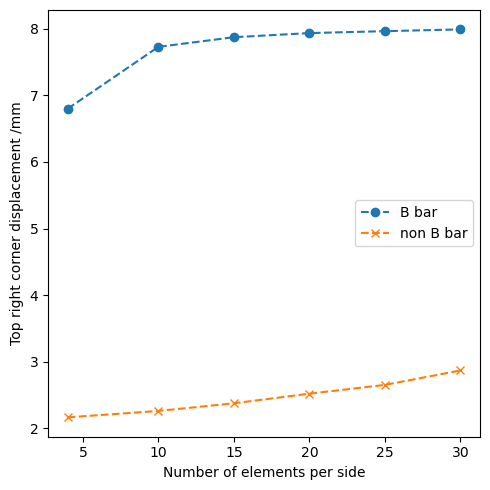

In [43]:
plot_data(ne, uys_at_top_bbar, uys_at_top_non_bbar, "b_bar_linear.png")

### Contour plot

In [44]:
import matplotlib.tri as tri
import vtuIO

nedges = ["4", "10", "15", "20", "25", "30"]


def contour_plot(pvd_file_name, title):
    file_name = get_last_vtu_file_name(pvd_file_name)
    m_plot = vtuIO.VTUIO(file_name, dim=2)
    triang = tri.Triangulation(m_plot.points[:, 0], m_plot.points[:, 1])
    triang = tri.Triangulation(m_plot.points[:, 0], m_plot.points[:, 1])
    s_plot = m_plot.get_point_field("sigma")
    s_trace = s_plot[:, 0] + s_plot[:, 1] + s_plot[:, 2]
    u_plot = m_plot.get_point_field("displacement")

    fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
    ax[0].set_title(title, loc="left", y=1.12)
    plt.subplots_adjust(wspace=0.5)

    contour_stress = ax[0].tricontourf(triang, s_trace, cmap="viridis")
    contour_displacement = ax[1].tricontourf(triang, u_plot[:, 1], cmap="gist_rainbow")
    fig.colorbar(contour_stress, ax=ax[0], label="Stress trace / MPa")
    fig.colorbar(contour_displacement, ax=ax[1], label="Dispplacement / m")
    fig.tight_layout()
    plt.savefig(pvd_file_name + ".png")
    plt.show()

#### Results obtained without the B bar method:

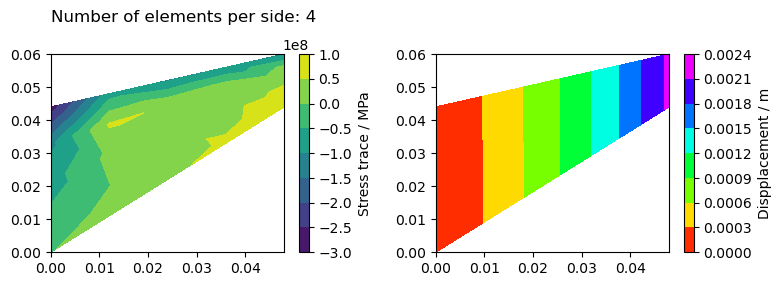

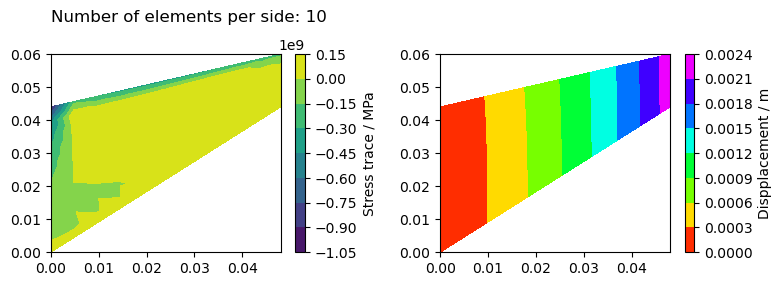

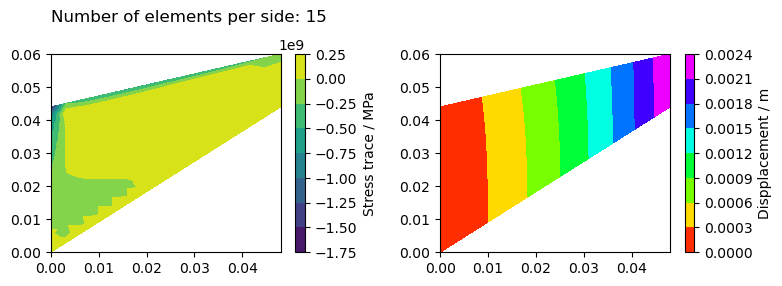

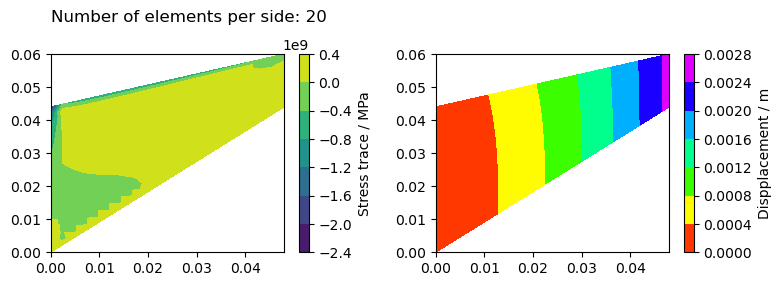

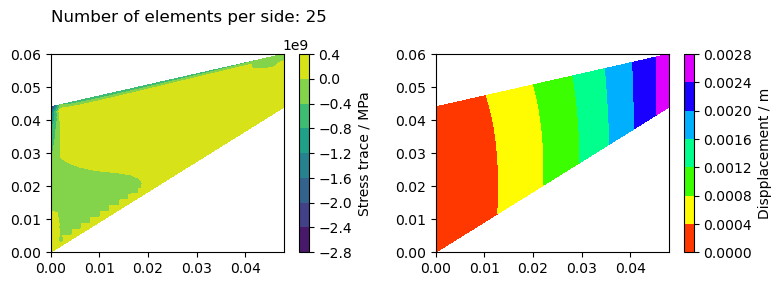

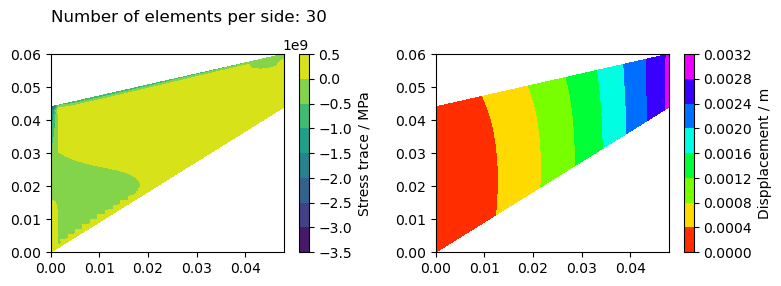

In [45]:
for nedge, output_prefix in zip(nedges, output_prefices_non_bbar):
    contour_plot(output_prefix + ".pvd", "Number of elements per side: " + nedge)

#### Results obtained with the B bar method:

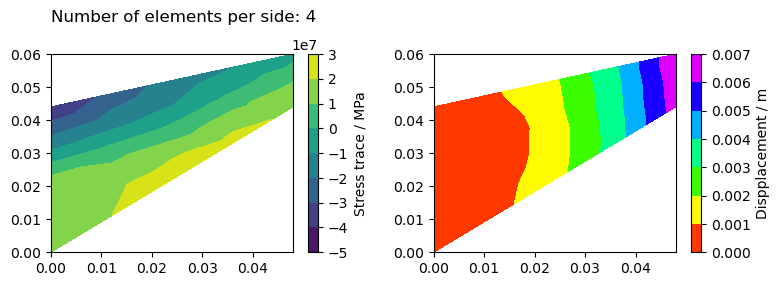

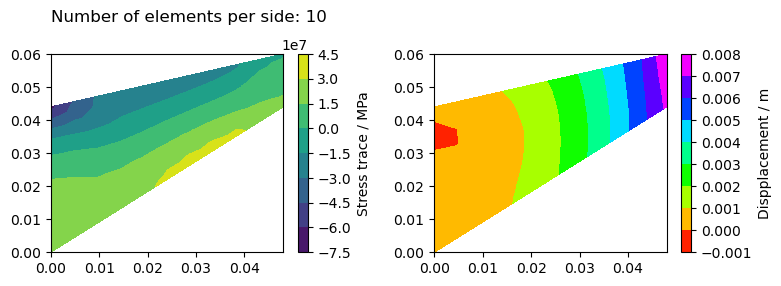

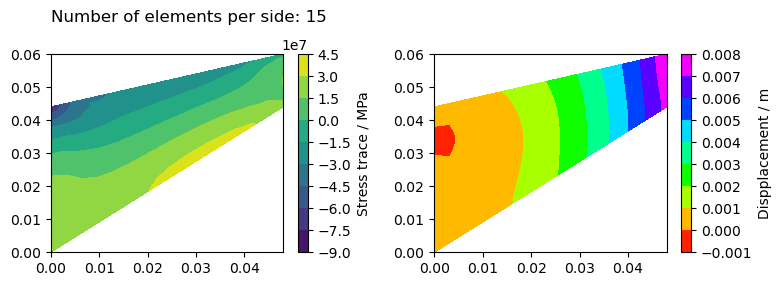

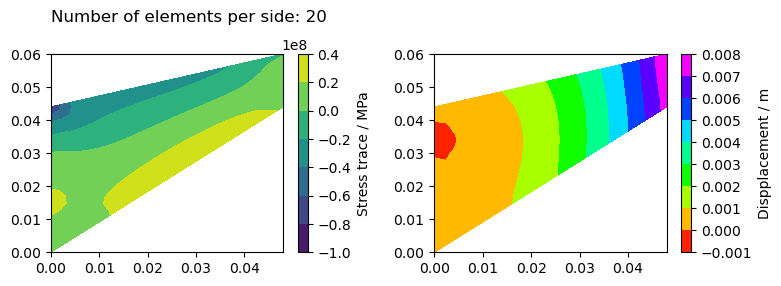

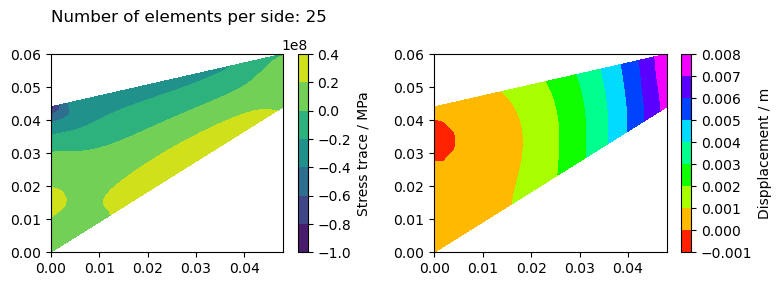

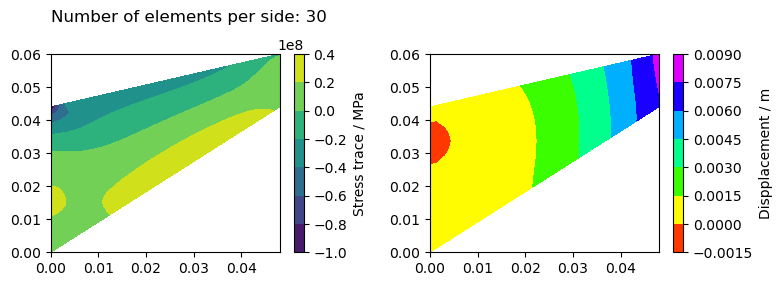

In [46]:
for nedge, output_prefix in zip(nedges, output_prefices):
    contour_plot(output_prefix + ".pvd", "Number of elements per side: " + nedge)

The contour plots show that even with the coarsest mesh, the B bar method still gives reasonable stress result. 